In [1]:
#################################### IMPORTS ###################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import datetime
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [2]:
##################### INICIALIZACAO DE VARIAVEIS ################################################
index_arquivo = ['preco', 'hr_int']#, 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP'] #index do arquivo
steps = [] # 9h04 -> 17h50 a cada 5 segundos 
epocas = 1000 #quantidade de vezes que vai rodar todos os dias
janela = 10 #janela de valores
n_variaveis = len(index_arquivo) #'preco', 'hr_int', 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP'
l = n_variaveis-1
n_mercado = n_variaveis*janela #inputs
n_estados = 2 #ncont e valor
n_neuronios = 216 #numero de neuronios da camada escondida
lim_cont = 5
n_saidas = 2*lim_cont+1   #numero de saidas da rede (compra, vende, segura)
custo = 1.06/2 #custo da operao
melhor_reward = 0

versao_arquivo = 2

carregar_pesos = False
carregar_epoca_epsilon = False
epoca_init = 0
if carregar_epoca_epsilon:
    file = open("./epoca_epsilon.txt", "r")
    valores = file.read().split(',')
    epoca_init = int(valores[0])
    epsilon = float(valores[1])
    file.close()
else:
    epsilon = 1. #valor de epsilon
epsilon_min = 0.01 #valor minimo de epsilon
epsilon_decay = (epsilon - epsilon_min) / (epocas - epoca_init) #o valor que vai retirado do epsilon por epoca

rewards = [0] #variavel para guardar rewards
plotx = [0] #variavel para guardar valores a serem plotados do eixo x

In [3]:
####################### LEITURA DOS DADOS #######################################################
dias = 220

caminho_arquivo = ('./consolidado.csv')
arquivo = pd.read_csv(caminho_arquivo) #le arquivo
inputs = arquivo[index_arquivo]
print(inputs['preco'][0:2])
if versao_arquivo == 1: #se quiser usar apenas os dias com IND e ISP
    inputs = inputs[inputs['IND'] != 0]
    arquivo = arquivo[arquivo['IND'] != 0]

dt = arquivo['dt'].values #cria coluna apenas dos dias

steps = []
ultimo_dia = 0
dias_para_rodar = [] #variavel para colocar os dias a serem rodados
j = 0
hr = []
h = 0

for i in range( 0, len(dt) ):    
    if (dt[i] != ultimo_dia):
        steps.append(i) #numero de linhas entre dias
        ultimo_dia = dt[i]
        dias_para_rodar.append(j) #numero do dia
        j += 1
        h = 0
    hr.append(h)
    h += 1
step_max = np.amax(hr)
batch = step_max + 1

#normalizacao dos dados
hr = hr/step_max
inputs['hr_int'] = hr
pmean = np.mean( inputs.loc[:dias*batch, inputs.columns[0]] ) #define valor minimo do preco  #step = 106
pstd = np.std( inputs.loc[:dias*batch, inputs.columns[0]] ) #define valor maximo do preco
for i in range( inputs.shape[1] ): #roda normalizo para todas as colunas
    imean = np.mean( inputs.loc[:dias*batch, inputs.columns[i]] ) #pega valor maximo
    istd = np.std( inputs.loc[:dias*batch, inputs.columns[i]] ) #pega valor minimo
    
    inputs.loc[:, inputs.columns[i]] = ( inputs.loc[:, inputs.columns[i]] - imean ) / istd #normaliza prs
    
mini_batch_size = int(dias*batch*0.1)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    3907.5
1    3900.0
Name: preco, dtype: float64


D:\anaconda\lib\site-packages\pandas\core\indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [4]:
########################################   BIBLIOTECAS ####################################
import random
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, concatenate
from keras import optimizers
from keras import backend as K            #importa backend para clear_session()


##################### MODELO DQN ####################################################
class DQNAgent:
    ########################### INICIALIZA ###########################################
    def __init__(self, state_size, mkt_size, action_size, epsilon, janela, n_neuronios, n_variaveis):
        self.state_size = state_size
        self.mkt_size = mkt_size
        self.n_neuronios = n_neuronios
        self.action_size = action_size
        self.n_variaveis = n_variaveis
        self.limpa_memoria_dia()
        self.limpa_memoria_epoca()
        self.gamma = 0.97       # discount rate
        self.epsilon = epsilon  # exploration rate
        self.learning_rate = 1e-4
        self.model = self.cria_modelo()
        self.model.summary()
        self.state = []
        self.next_state = []
        self.janela_precos = []
        self.prox_janela_precos = []

################################# REDE NEURAL ###########################################
    def cria_modelo(self):
        # Neural Net for Deep-Q learning Model
        #inputs
        x1 = Input(shape=(self.state_size,))
        x2 = Input(shape=(self.mkt_size,))
        
        #state hidden layers
        a1 = Dense(320)(x1)
        a2 = Dense(256)(a1)
        a3 = Dense(256)(a2)
        
        #mkt hidden layers
        b1 = Dense(320)(x2)
        b2 = Dense(256)(b1)
        b3 = Dense(256)(b2)
        
        #concatenacao
        x12 = concatenate([a3, b3], axis=-1)
        
        #camada de saida
        y = Dense(self.action_size, activation='linear')(x12)
        
        model = Model(inputs=[x1, x2], outputs=y)
        
        sgd = optimizers.SGD(lr=self.learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='mean_squared_error', optimizer=sgd)
        return model

    def limpa_memoria_dia(self):
        self.janela_precos = np.zeros(self.mkt_size)
        self.prox_janela_precos = np.zeros(self.mkt_size)
        self.state = []
        self.next_state = []
    
    def limpa_memoria_epoca(self):
        self.memory = []
        
    def toma_acao(self):
        if np.random.rand() <= self.epsilon: #se o numero aleatorio for menor que o epsilon
            return random.randrange(self.action_size) #retorna acao aleatoria     
        act_values = self.model.predict([self.state, self.janela_precos]) #calcula qual a melhor acao
        return np.argmax(act_values[0])  # returns action
    
    def treina_modelo(self, batch_size=mini_batch_size):
        minibatch = random.sample(self.memory, batch_size)
        
        x1 = np.zeros((batch_size+1, self.state_size))
        x2 = np.zeros((batch_size+1, self.mkt_size))
        y = np.zeros((batch_size+1, self.action_size))
        i = 0
        for acao, reward, estado, mercado, prox_estado, prox_mercado, done in minibatch:        
            
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict([prox_estado, prox_mercado])[0])) #pega valor que quer chegar

            target_f = self.model.predict([estado, mercado]) #pega valor que chegou
            target_f[0][acao+lim_cont] = target #define o valor que deseja chegar
            x1[i,:] = estado
            x2[i,:] = mercado
            y[i,:] = target_f
            i = i + 1
            
        self.model.fit([x1, x2], y, epochs=1, verbose=0) #treina modelo
            
    def remember(self, acao, reward, done):
        self.memory.append((acao, reward, self.state, self.janela_precos, self.next_state, self.prox_janela_precos, done))
    
    def carrega_pesos(self, name):
        self.model.load_weights(name) #carrega pesos

    def salva_pesos(self, name):
        self.model.save_weights(name) #salva pesos
                
########################  DECLARA MODELO ################################
modelo = DQNAgent(n_estados, n_mercado, n_saidas, epsilon, janela, n_neuronios, n_variaveis)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 320)          960         input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 320)          6720        input_2[0][0]                    
____________________________________________________________________________________________

In [5]:
########################### FUNCOES ###############################################################

def atuacao( preco, ncont, acao, custo, valor ):  #preo atual, n de contratos posicionados,
                                                #acaoo atual, custo, valor da posio
    preco_cheio = 0.
    valor_cheio = 0.
    ncont_anterior = ncont #salva posio anterior
    ncont = acao #posicao atual = acao
    reward = 0.
    posicao = 0.
    dp = 0.

    
    #variaveis para tratamento do sinal de ncont, ncont_anterior e da acao
    acao = ncont - ncont_anterior  #ajuda a manter as condições anteriores
    var1 = ncont*ncont_anterior
    var2 = ncont*acao

    if acao != 0:
        #realizacao de lucros e custos
        if ((var2>0) and (var1>=0)):
            #aumento da posicao
            reward = -custo*abs(acao)    #reward = -custo*acao se houve operacao (aumento da posicao)
            #aumento da posicao = preco medio:
            valor = (ncont_anterior*valor + acao*preco)/ncont  
            
        else:
            valor_cheio = valor * pstd + pmean  #valores nao normalizados
            preco_cheio = preco * pstd + pmean
            if (var1)>= 0:
                #diminuicao da posicao
                reward = acao*(valor_cheio - preco_cheio)*10 - custo*abs(acao)  #reward se houve diminuicao da posicao
                #valor medio nao muda na diminuicao, somente se ncont==0:
                if ncont==0: valor=-10
                    
            else:
                #troca de posicao
                reward = (-ncont_anterior)*(valor_cheio - preco_cheio)*10 - custo*abs(acao)  #reward se houve troca da posicao
                #preco medio da posicao = preco da troca de posicao
                valor = preco
    
    #definindo o lucro potencial da carteira(posicao)
    if valor!=-10:
        valor_cheio = valor * pstd + pmean  #valor posicionado atual      
        dp = (preco * pstd + pmean) - valor_cheio #variacao do preco atual e do preco de compra/venda
        posicao = ncont * dp * 10 - custo*abs(ncont)           #posicao = lucro (POTENCIAL)
        
    return ncont, valor, posicao, reward

def obter_acao(ncont):
    decisao = modelo.toma_acao() #calcula a saida da rede neural
    return (decisao - lim_cont)

def rodar_1dia(precos, custo, dia):
    global melhor_reward
    ncont = 0 #cria variavel de quantidade de contratos
    ncont_anterior = 0 #cria variavel para quantidade de contratos anterior
    valor = -10 #cria variavel para preo medio
    reward = 0. #cria variavel para recompensa
    lucro = 0.
    posicao = 0 #cria variavel de posio 
    erro = []
    modelo.limpa_memoria_dia() #limpa o vetor de memoria
    done = False
    posicao_max = 10e4
    shp = modelo.janela_precos.shape
    
    for step in range( steps[dia - 1], steps[dia] ):  #roda os dados
        
        ultimos_precos = precos[ step : step + 1 ] #pega os valores de agora
        modelo.janela_precos = np.reshape(np.delete(np.insert(modelo.janela_precos,shp,np.concatenate(ultimos_precos.values).tolist()),[0,l]), (1,modelo.mkt_size))
        modelo.state = np.reshape([ncont/lim_cont, valor], (1,modelo.state_size)) #adiciona na variavel de estado      
        
        acao = obter_acao(ncont)        
        ncont, valor, posicao, reward = atuacao(precos['preco'][step], ncont, acao, custo, valor)
        
        #pos acao
        lucro += reward    #LUCRO ACUMULADO
        
        #v=valor if valor==-10 else valor*pstd+pmean
        #p=precos['preco'][step]*pstd+pmean
        #print("acao={0}; ncont={1}; valor={2}; preco={3}; posicao={4}; lucro={5}; reward={6}".format(acao, ncont, v, p, posicao, lucro, reward))   

        if step == (steps[dia] - 1): #se ultimo step do dia
            done = True     
            prox_precos = np.zeros(n_variaveis)
            modelo.prox_janela_precos = np.reshape(np.delete(np.insert(modelo.prox_janela_precos,shp,prox_precos),[0,l]),(1,modelo.mkt_size))
        else:
            prox_precos = precos[ step + 1 : step + 2 ] #pega os proximos valores
            modelo.prox_janela_precos = np.reshape(np.delete(np.insert(modelo.prox_janela_precos,shp,np.concatenate(prox_precos.values).tolist()),[0,l]),(1,modelo.mkt_size))
        
        modelo.next_state = np.reshape([ncont/lim_cont, valor], (1,modelo.state_size)) #adiciona na variavel de estado      
        modelo.remember(acao, posicao, done)  #salva step na memoria - reward = lucro instantaneo que a ação gerou
        
    #fim do dia
    lucro += posicao

    #print("ncont zerados={0}; posicao={1}".format(ncont, posicao))
    if lucro > melhor_reward:
        melhor_reward = lucro
    return lucro #retorna o valor do reward

dias_pos = 0
dias_neg = 0

def rodar_dias(precos, custo):   
    global dias_pos
    global dias_neg
    sum_rewards = 0 #cria variavel de somatoria de recompensas
    
    for dia in range( 1, dias ): #loop de dias
        reward = rodar_1dia(precos, custo, dia)
        sum_rewards += reward #roda 1 dia e adiciona o total na variavel de somatoria
        
        if reward>0: 
            dias_pos += 1
        elif reward<0:
            dias_neg += 1
    return sum_rewards


W1106 22:42:27.413546  4920 deprecation_wrapper.py:119] From D:\anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



resultado da epoca 0 = -36030.26 Epsilon = 1.000
80
139
resultado da epoca 1 = -37028.30 Epsilon = 0.999
92
127
resultado da epoca 2 = -16526.32 Epsilon = 0.998
99
120
resultado da epoca 3 = -61147.56 Epsilon = 0.997
93
126
resultado da epoca 4 = -68259.32 Epsilon = 0.996
79
140
resultado da epoca 5 = -41459.90 Epsilon = 0.995
91
128
resultado da epoca 6 = -86949.74 Epsilon = 0.994
78
141
resultado da epoca 7 = -34479.68 Epsilon = 0.993
96
123
resultado da epoca 8 = -40952.26 Epsilon = 0.992
94
125
resultado da epoca 9 = -30400.06 Epsilon = 0.991
97
122
resultado da epoca 10 = -58655.52 Epsilon = 0.990
90
129
resultado da epoca 11 = -29289.98 Epsilon = 0.989
104
115
resultado da epoca 12 = -46487.06 Epsilon = 0.988
94
125
resultado da epoca 13 = -36619.00 Epsilon = 0.987
89
130
resultado da epoca 14 = -39216.66 Epsilon = 0.986
90
129
resultado da epoca 15 = -40787.44 Epsilon = 0.985
94
125
resultado da epoca 16 = -74210.10 Epsilon = 0.984
84
135
resultado da epoca 17 = -33709.14 Epsilo

resultado da epoca 143 = -34566.42 Epsilon = 0.858
92
127
resultado da epoca 144 = -39646.48 Epsilon = 0.857
96
123
resultado da epoca 145 = -23090.80 Epsilon = 0.856
100
119
resultado da epoca 146 = -28169.32 Epsilon = 0.855
109
110
resultado da epoca 147 = -40516.62 Epsilon = 0.854
92
127
resultado da epoca 148 = -69726.16 Epsilon = 0.853
87
132
resultado da epoca 149 = -46584.60 Epsilon = 0.852
90
129
resultado da epoca 150 = -40956.14 Epsilon = 0.851
88
131
resultado da epoca 151 = -27844.22 Epsilon = 0.851
98
121
resultado da epoca 152 = -15675.02 Epsilon = 0.850
99
120
resultado da epoca 153 = -39876.92 Epsilon = 0.849
95
124
resultado da epoca 154 = -69107.64 Epsilon = 0.848
86
133
resultado da epoca 155 = -25206.20 Epsilon = 0.847
93
126
resultado da epoca 156 = -46410.42 Epsilon = 0.846
95
124
resultado da epoca 157 = -29874.16 Epsilon = 0.845
95
124
resultado da epoca 158 = -37530.76 Epsilon = 0.844
86
133
resultado da epoca 159 = -48168.98 Epsilon = 0.843
98
121
resultado da

resultado da epoca 285 = -24961.62 Epsilon = 0.718
99
120
resultado da epoca 286 = -72108.70 Epsilon = 0.717
86
133
resultado da epoca 287 = -82712.84 Epsilon = 0.716
79
140
resultado da epoca 288 = -2410.36 Epsilon = 0.715
112
107
resultado da epoca 289 = -48408.28 Epsilon = 0.714
85
134
resultado da epoca 290 = -33038.78 Epsilon = 0.713
99
120
resultado da epoca 291 = -59325.62 Epsilon = 0.712
92
127
resultado da epoca 292 = -29674.36 Epsilon = 0.711
96
123
resultado da epoca 293 = -46245.46 Epsilon = 0.710
95
124
resultado da epoca 294 = -58302.50 Epsilon = 0.709
85
134
resultado da epoca 295 = -52062.14 Epsilon = 0.708
88
131
resultado da epoca 296 = -34106.22 Epsilon = 0.707
94
125
resultado da epoca 297 = -50224.88 Epsilon = 0.706
87
132
resultado da epoca 298 = -80590.14 Epsilon = 0.705
87
132
resultado da epoca 299 = -60942.50 Epsilon = 0.704
90
129
resultado da epoca 300 = -55588.54 Epsilon = 0.703
95
124
resultado da epoca 301 = -52246.94 Epsilon = 0.702
89
130
resultado da e

resultado da epoca 427 = -54374.78 Epsilon = 0.577
98
121
resultado da epoca 428 = -56230.84 Epsilon = 0.576
80
139
resultado da epoca 429 = -49678.48 Epsilon = 0.575
99
120
resultado da epoca 430 = -74835.58 Epsilon = 0.574
84
135
resultado da epoca 431 = -55566.68 Epsilon = 0.573
86
133
resultado da epoca 432 = -35744.36 Epsilon = 0.572
92
127
resultado da epoca 433 = -65367.92 Epsilon = 0.571
81
138
resultado da epoca 434 = -33605.14 Epsilon = 0.570
96
123
resultado da epoca 435 = -42730.76 Epsilon = 0.569
106
113
resultado da epoca 436 = -25384.70 Epsilon = 0.568
103
116
resultado da epoca 437 = -49589.76 Epsilon = 0.567
98
121
resultado da epoca 438 = -46771.08 Epsilon = 0.566
93
126
resultado da epoca 439 = -46183.94 Epsilon = 0.565
94
125
resultado da epoca 440 = -16613.54 Epsilon = 0.564
107
112
resultado da epoca 441 = -34035.30 Epsilon = 0.563
101
118
resultado da epoca 442 = -79341.20 Epsilon = 0.562
86
133
resultado da epoca 443 = -49258.38 Epsilon = 0.561
100
119
resultado

resultado da epoca 568 = -80754.38 Epsilon = 0.438
80
139
resultado da epoca 569 = -51015.42 Epsilon = 0.437
91
128
resultado da epoca 570 = -66176.28 Epsilon = 0.436
94
125
resultado da epoca 571 = -53254.98 Epsilon = 0.435
89
130
resultado da epoca 572 = -47997.78 Epsilon = 0.434
91
128
resultado da epoca 573 = -11300.74 Epsilon = 0.433
101
118
resultado da epoca 574 = -40514.66 Epsilon = 0.432
98
121
resultado da epoca 575 = -49220.36 Epsilon = 0.431
87
132
resultado da epoca 576 = -28777.74 Epsilon = 0.430
94
125
resultado da epoca 577 = -34193.52 Epsilon = 0.429
96
123
resultado da epoca 578 = -32373.34 Epsilon = 0.428
101
118
resultado da epoca 579 = -17726.84 Epsilon = 0.427
111
108
resultado da epoca 580 = -86431.02 Epsilon = 0.426
80
139
resultado da epoca 581 = -25446.70 Epsilon = 0.425
98
121
resultado da epoca 582 = -53019.52 Epsilon = 0.424
102
117
resultado da epoca 583 = -40052.88 Epsilon = 0.423
101
118
resultado da epoca 584 = -55548.76 Epsilon = 0.422
82
137
resultado

resultado da epoca 709 = -32431.64 Epsilon = 0.298
100
119
resultado da epoca 710 = -37598.90 Epsilon = 0.297
96
123
resultado da epoca 711 = -45173.84 Epsilon = 0.296
95
124
resultado da epoca 712 = -44102.48 Epsilon = 0.295
95
124
resultado da epoca 713 = -21191.04 Epsilon = 0.294
105
114
resultado da epoca 714 = -21867.76 Epsilon = 0.293
94
125
resultado da epoca 715 = -26057.34 Epsilon = 0.292
106
113
resultado da epoca 716 = -31441.94 Epsilon = 0.291
98
121
resultado da epoca 717 = -40052.74 Epsilon = 0.290
93
126
resultado da epoca 718 = -44287.74 Epsilon = 0.289
95
124
resultado da epoca 719 = -33471.74 Epsilon = 0.288
101
118
resultado da epoca 720 = -13828.28 Epsilon = 0.287
96
123
resultado da epoca 721 = -43668.26 Epsilon = 0.286
98
121
resultado da epoca 722 = -31666.88 Epsilon = 0.285
96
123
resultado da epoca 723 = -27505.50 Epsilon = 0.284
90
129
resultado da epoca 724 = -30044.70 Epsilon = 0.283
105
114
resultado da epoca 725 = -27901.20 Epsilon = 0.282
94
125
resultado

resultado da epoca 850 = -33640.56 Epsilon = 0.158
102
117
resultado da epoca 851 = -10229.24 Epsilon = 0.158
108
111
resultado da epoca 852 = -26242.76 Epsilon = 0.157
97
122
resultado da epoca 853 = -8858.92 Epsilon = 0.156
109
110
resultado da epoca 854 = -45431.38 Epsilon = 0.155
94
125
resultado da epoca 855 = -25317.52 Epsilon = 0.154
97
122
resultado da epoca 856 = -7921.06 Epsilon = 0.153
105
114
resultado da epoca 857 = -18561.26 Epsilon = 0.152
98
121
resultado da epoca 858 = -14986.80 Epsilon = 0.151
100
119
resultado da epoca 859 = -37537.78 Epsilon = 0.150
95
124
resultado da epoca 860 = -5443.90 Epsilon = 0.149
102
117
resultado da epoca 861 = -27755.16 Epsilon = 0.148
100
119
resultado da epoca 862 = -15293.52 Epsilon = 0.147
96
123
resultado da epoca 863 = -15007.62 Epsilon = 0.146
101
118
resultado da epoca 864 = -22154.80 Epsilon = 0.145
101
118
resultado da epoca 865 = -5277.46 Epsilon = 0.144
105
114
resultado da epoca 866 = -35759.54 Epsilon = 0.143
99
120
resultad

resultado da epoca 992 = -8405.08 Epsilon = 0.018
100
119
resultado da epoca 993 = 1547.88 Epsilon = 0.017
97
122
resultado da epoca 994 = -7789.54 Epsilon = 0.016
95
124
resultado da epoca 995 = -11474.22 Epsilon = 0.015
98
121
resultado da epoca 996 = -11219.96 Epsilon = 0.014
97
122
resultado da epoca 997 = -10718.68 Epsilon = 0.013
98
121
resultado da epoca 998 = -8805.60 Epsilon = 0.012
96
123
resultado da epoca 999 = -6994.96 Epsilon = 0.011
95
124
resultado da epoca 1000 = -8309.48 Epsilon = 0.010
93
126
resultado da epoca 1001 = -9730.58 Epsilon = 0.010
94
125
resultado da epoca 1002 = -3170.34 Epsilon = 0.010
96
123
resultado da epoca 1003 = -701.94 Epsilon = 0.010
96
123
resultado da epoca 1004 = -5257.26 Epsilon = 0.010
98
121
0
0
Melhor resultado diario: 9025.64


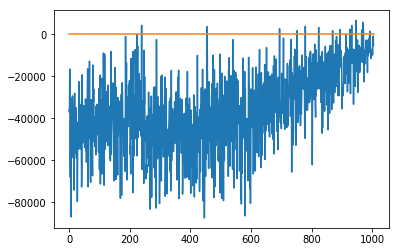

In [6]:
import time
##################################  MAIN  #########################################
if __name__ == "__main__":
    global dias_pos
    global dias_neg
    sum_rewards_total = 0
    sr=[]
    try:
        if carregar_pesos:
            modelo.carrega_pesos('./pesos.h5')
        epoca_parou = epoca_init
        for epoca in range(epoca_init, epocas+5): #rodar uma quantidade de epocas
            modelo.limpa_memoria_epoca()
            sum_rewards = rodar_dias(inputs, custo) #adiciona o resultado da epoca na somatoria
            modelo.treina_modelo() #roda o modelo com toda a memoria da epoca
            sum_rewards_total += sum_rewards
            sr.append(sum_rewards)
            print("resultado da epoca {0} = {1:0.2f} Epsilon = {2:0.3f}".format(epoca, sum_rewards, modelo.epsilon))
            print(dias_pos)
            print(dias_neg)
            epoca_parou += 1
            if ((epoca % 200) == 0):
                modelo.salva_pesos('./pesos_5.h5')
            dias_pos = 0
            dias_neg = 0            
            if modelo.epsilon <= epsilon_min:
                modelo.epsilon = epsilon_min
            else:
                modelo.epsilon -= epsilon_decay
    finally:
        print(dias_pos)
        print(dias_neg)
        modelo.salva_pesos('./pesos2.h5')
        if carregar_epoca_epsilon:
            file = open("./epoca_epsilon.txt", "w")
            file.writelines("{0},{1}".format(epoca_parou, modelo.epsilon))
            file.close()
            print("parou na epoca {0} com epsilon {1}".format(epoca_parou, modelo.epsilon))
            
        print("Melhor resultado diario: {0:0.2f}".format(melhor_reward))
        plt.plot(range(0, len(sr)), sr, range(0, len(sr)), np.zeros(len(sr))) #plota os valores de reward por epoca